In [56]:
import numpy as np
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
from labellines import labelLines
from scipy.stats import binom

In [57]:
interest = 0.04
numPeriods = 6
optionType = "Call"
# optionType = "Put"
timeToExpiration = 1
dt = timeToExpiration / numPeriods
vol = 0.04
up = np.round(np.exp(vol * np.sqrt(dt)), 4)
# up = 1.05
down = 1/up
spot = 100
strike = 104
p = ((1 + interest*(timeToExpiration/numPeriods)) - down) / (up - down)


def create_level(previousLevel, up, down):
    newLevel = []
    for i in previousLevel:
        newLevel.append(round(i * down, 2))
    newLevel.append(round(previousLevel[-1]*up, 2))
    return newLevel

def create_pricing_tree(spot, up, down, numPeriods):
    pricingTree = [[spot]]
    count = 1
    while count <= numPeriods:
        pricingTree.append(create_level(pricingTree[-1], up, down))
        count = count + 1
    return pricingTree

def plot_pricing_tree(pricingTree):
    numPeriods = len(pricingTree) - 1
    mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)

    for i in range(numPeriods+1):
                value = pricingTree[i]
                rows = np.zeros(i+1, dtype=np.int16) + i
                cols = np.arange(i+1)*2+numPeriods-i
                mat[rows, cols] = value

    fig = plt.figure(figsize=[15, 7])
    plt.axis('off')
    plt.title('')

    for i in range(numPeriods):
        x = (np.arange(3 + i*2) % 2 == 0) + i
        y = np.arange(0, 2*(i+1)+1) - 1 + (numPeriods-i)
        v = mat[x, y].toarray()[0]
        plt.plot(x, v, 'bo-')
        for i in range(len(x)- 1):
            plt.text((x[i] + x[i+1]) / 2, (v[i] + v[i+1]) / 2, f'{1 - abs(((i % 2) - p)):.2f}', fontsize=12, ha='center', va='bottom')
    
        for xi, vi in zip(x, v):
            plt.text(xi, vi, f'{vi:.2f}', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

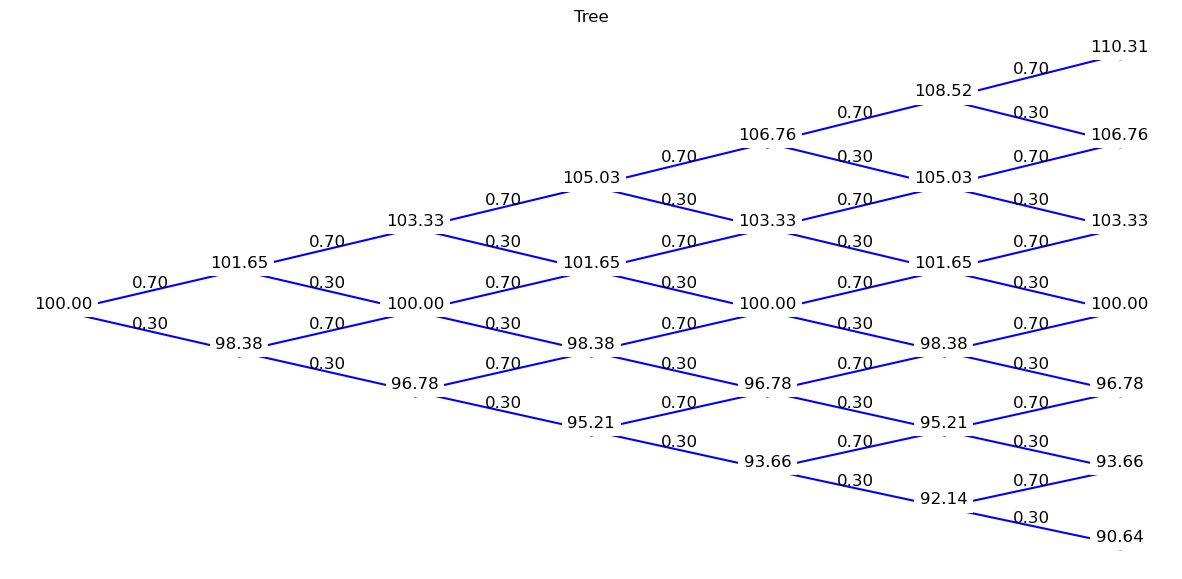

In [58]:
pricingTree = create_pricing_tree(spot, up, down, numPeriods)
plot_pricing_tree(pricingTree)

In [59]:


def create_call_value_level(previousLevel, p):
    newLevel = []
    for i in range(len(previousLevel) - 1):
        newLevel.append(round(((1-p) * previousLevel[i] + p * previousLevel[i+1]) / (1+(interest*timeToExpiration/numPeriods)), 2))
    return newLevel

def create_call_value_tree(pricingTreeLastLevel, strike):
    call_value_tree = []
    currentLevel = [round(max(0, item - strike), 2) for item in pricingTreeLastLevel]
    while(len(currentLevel) > 0):
        call_value_tree.append(currentLevel)
        currentLevel = create_call_value_level(currentLevel,p)
    call_value_tree.reverse()
    return call_value_tree

In [60]:

call_value_tree = create_call_value_tree(pricingTree[-1], strike)

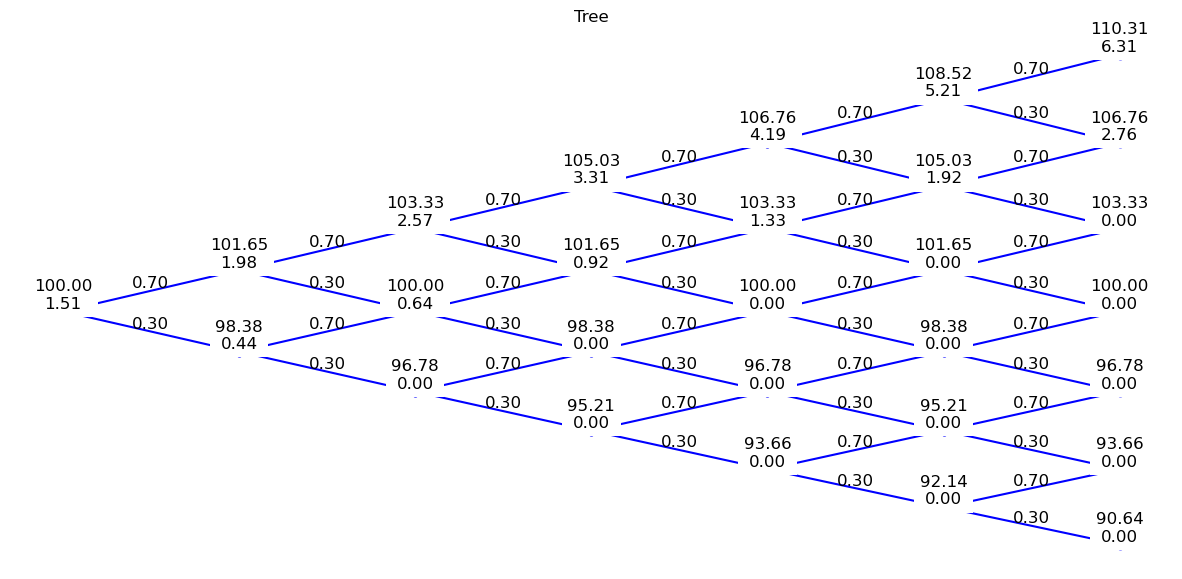

In [61]:
def plot_call_value_tree(pricingTree, call_value_tree):
    numPeriods = len(pricingTree) - 1
    mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    call_mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    for i in range(numPeriods+1):
                value = pricingTree[i]
                call_value = call_value_tree[i]
                rows = np.zeros(i+1, dtype=np.int16) + i
                cols = np.arange(i+1)*2+numPeriods-i
                mat[rows, cols] = value
                call_mat[rows, cols] = call_value

    fig = plt.figure(figsize=[15, 7])
    plt.axis('off')
    plt.title('Tree')

    for i in range(numPeriods):
        x = (np.arange(3 + i*2) % 2 == 0) + i
        y = np.arange(0, 2*(i+1)+1) - 1 + (numPeriods-i)
        v = mat[x, y].toarray()[0]
        call_v = call_mat[x, y].toarray()[0]
        plt.plot(x, v, 'bo-')
        for i in range(len(x)- 1):
            plt.text((x[i] + x[i+1]) / 2, (v[i] + v[i+1]) / 2, f'{1 - abs(((i % 2) - p)):.2f}', fontsize=12, ha='center', va='bottom',)


        for xi, vi, ci in zip(x, v, call_v):
            plt.text(xi, vi, f'{vi:.2f}\n{ci:.2f}', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

plot_call_value_tree(pricingTree, call_value_tree)

In [62]:
def create_delta_tree(pricingTree, call_value_tree):
    delta_tree = []
    for i in range(1, depth + 1):
        priceTree = pricingTree[i]
        callTree = call_value_tree[i]
        currentLevel = []
        for j in range(i):
            currentLevel.append(round((callTree[j+1] - callTree[j]) / (priceTree[j+1] - priceTree[j])  * 100, 0))
        delta_tree.append(currentLevel)
    return delta_tree

delta_tree = create_delta_tree(pricingTree, call_value_tree)
        

In [63]:
def plot_delta_tree(pricingTree, call_value_tree, delta_tree):
    numPeriods = len(pricingTree) - 1
    mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    call_mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    delta_mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    for i in range(numPeriods+1):
                value = pricingTree[i]
                call_value = call_value_tree[i]
                rows = np.zeros(i+1, dtype=np.int16) + i
                cols = np.arange(i+1)*2+numPeriods-i
                mat[rows, cols] = value
                call_mat[rows, cols] = call_value
                if i == numPeriods:
                    break
                delta_value = delta_tree[i]
                delta_mat[rows, cols] = delta_value
    fig = plt.figure(figsize=[15, 7])
    plt.axis('off')
    plt.title('Tree')

    for i in range(numPeriods):
        x = (np.arange(3 + i*2) % 2 == 0) + i
        y = np.arange(0, 2*(i+1)+1) - 1 + (numPeriods-i)
        v = mat[x, y].toarray()[0]
        call_v = call_mat[x, y].toarray()[0]
        delta_v = delta_mat[x,y].toarray()[0]
        plt.plot(x, v, 'bo-')
        for j in range(len(x)- 1):
            plt.text((x[j] + x[j+1]) / 2, (v[j] + v[j+1]) / 2, f'{1 - abs(((j % 2) - p)):.2f}', fontsize=12, ha='center', va='bottom',)

        for j in range(len(x)):
            if i == numPeriods - 1  and j % 2 == 0:
                plt.text(x[j], v[j], f'{call_v[j]:.2f}', fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=1, edgecolor='none'))
            else:
                plt.text(x[j], v[j], f'{v[i]:.2f}\n{call_v[j]:.2f}\nΔ = {delta_v[j]:.2f}', fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

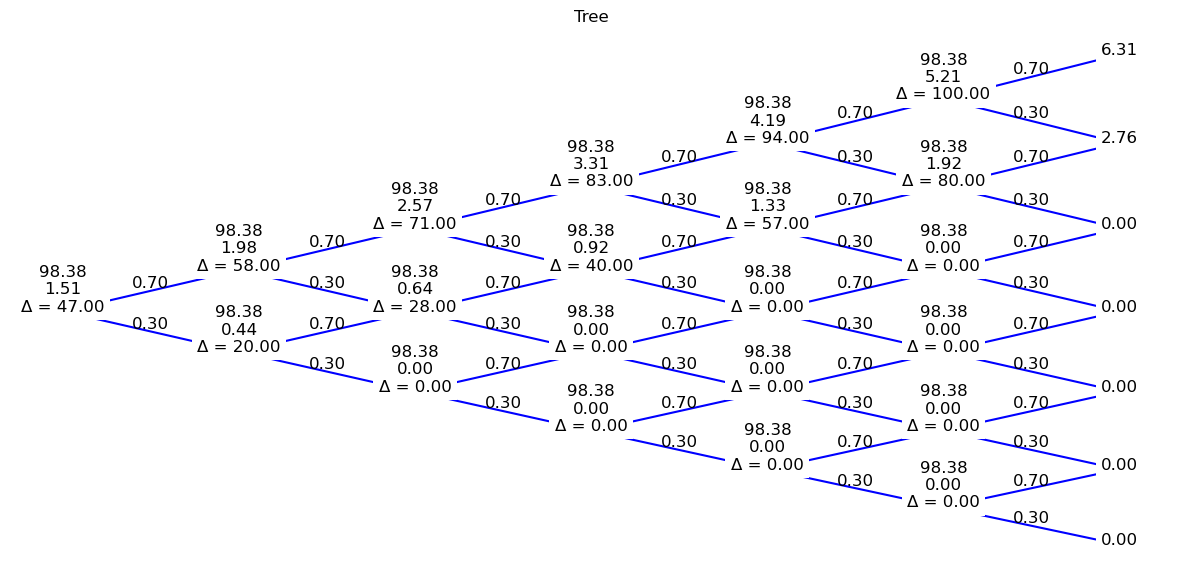

In [64]:
plot_delta_tree(pricingTree, call_value_tree, delta_tree)

In [73]:
def plot_tree(pricingTree, call_value_tree=None, delta_tree=None):
    numPeriods = len(pricingTree) - 1
    mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    call_mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    delta_mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    for i in range(numPeriods+1):
                value = pricingTree[i]
                rows = np.zeros(i+1, dtype=np.int16) + i
                cols = np.arange(i+1)*2+numPeriods-i
                mat[rows, cols] = value
                if call_value_tree is not None:
                    call_value = call_value_tree[i]
                    call_mat[rows, cols] = call_value
                if delta_tree is None:
                    continue
                if i == numPeriods:
                    break
                delta_value = delta_tree[i]
                delta_mat[rows, cols] = delta_value
    fig = plt.figure(figsize=[15, 7])
    plt.axis('off')
    plt.title('Tree')

    for i in range(numPeriods):
        x = (np.arange(3 + i*2) % 2 == 0) + i
        y = np.arange(0, 2*(i+1)+1) - 1 + (numPeriods-i)
        v = mat[x, y].toarray()[0]
        call_v = call_mat[x, y].toarray()[0]
        delta_v = delta_mat[x,y].toarray()[0]
        plt.plot(x, v, 'bo-')
        for j in range(len(x)- 1):
            plt.text((x[j] + x[j+1]) / 2, (v[j] + v[j+1]) / 2, f'{1 - abs(((j % 2) - p)):.2f}', fontsize=12, ha='center', va='bottom',)

        for j in range(len(x)):
            string = f'{v[j]:.2f}'
            if call_value_tree is not None:
                    string += f'\n{call_v[j]:.2f}'
            if not (i == numPeriods - 1  and j % 2 == 0):
                if delta_tree is not None: 
                    string += f'\nΔ = {delta_v[j]:.2f}'
            plt.text(x[j], v[j], string, fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

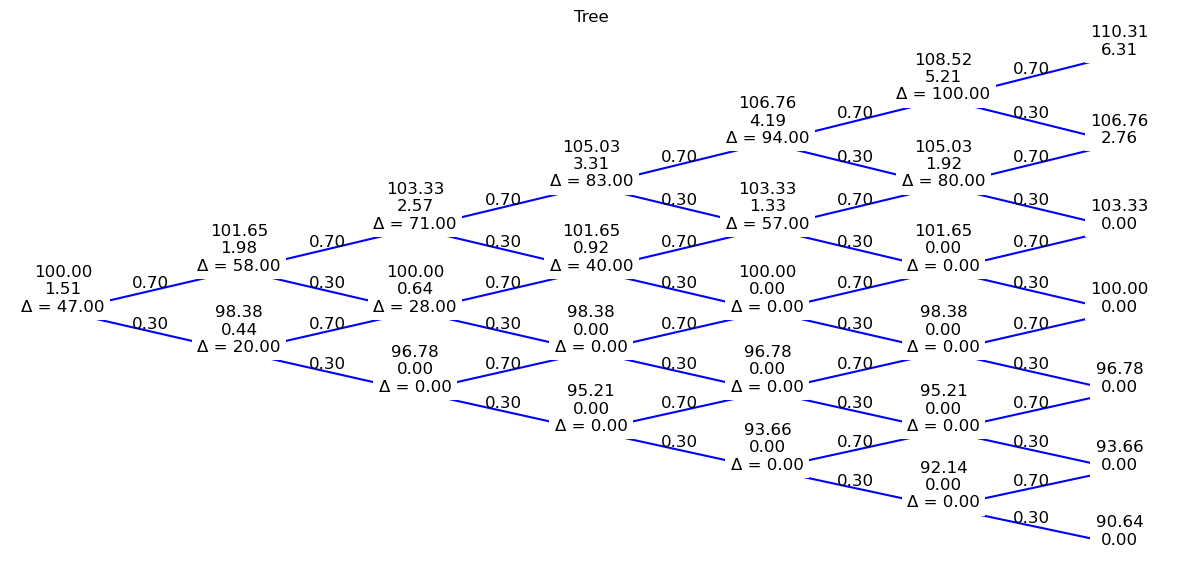

In [76]:
plot_tree(pricingTree, delta_tree=delta_tree, call_value_tree=call_value_tree)

In [65]:
import numpy as np
from scipy.stats import norm

N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)

print(BS_CALL(spot, strike, timeToExpiration, interest, vol))

1.6342930631442414


[0.000729 0.010206 0.059535 0.18522  0.324135 0.302526 0.117649]


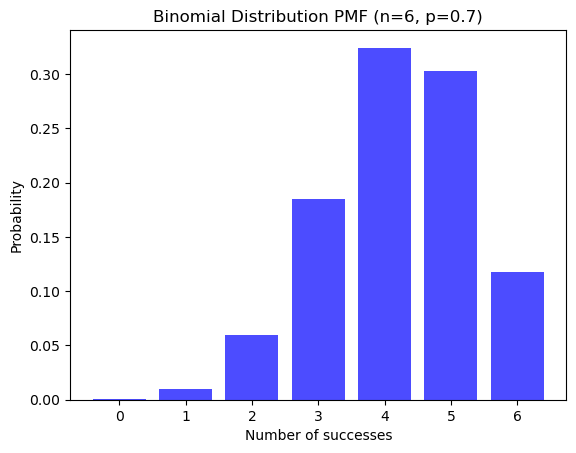

In [66]:
# Parameters
n = depth


# Range of possible number of successes
x = np.arange(0, n+1)

# Probability mass function (PMF)
pmf = binom.pmf(x, n, round(p,2))
print(pmf)

# Plotting
plt.bar(x, pmf, color='blue', alpha=0.7)
plt.xlabel('Number of successes')
plt.ylabel('Probability')
plt.title(f'Binomial Distribution PMF (n={n}, p={round(p,2)})')
plt.show()